In [1]:
import numpy as np
from matplotlib import mlab
from scipy.io.wavfile import read,write
from pylab import plot,show,subplot,specgram
import matplotlib.pyplot as plt
import librosa
from matplotlib.pyplot import specgram
import librosa.display 

In [2]:
def get_audio(paths):
    audio_data = np.array([])
    for path in paths:
        rate,data = read(path)
        np.concatenate[audio_data,data]
    return audio_data
    
    


In [3]:
import glob 
music_paths = np.array(glob.glob("SpeechMusic/music/*"))
speech_paths = np.array(glob.glob("SpeechMusic/speech/*"))

In [ ]:
music_files= get_audio(music_paths)
speech_files = get_audio(speech_path)

In [ ]:
speech_files.shape

In [157]:
#Use librosa to get certain features
def get_features(PATH, sec1= False):
    X, sample_rate = librosa.load(PATH)
    if sec1:
        X= X[:int((len(X))/15)]  #get the first 1 sec
     
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X)))
    return mfccs, chroma, mel, contrast, tonnetz



(1025, 646)
(2050, 646)


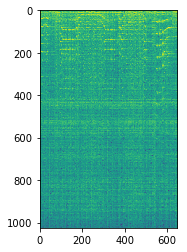

In [44]:
X, sample_rate = librosa.load("SpeechMusic/music/2.wav")
stft = np.abs(librosa.stft(X))
stftLog = np.log(stft)
plt.imshow(stftLog)
print(stft.shape)
hhj= np.vstack([stft,stft])
print(hhj.shape)
plt.show()

In [26]:
#stack the STFT and use them as audio features
def get_audio_features(paths):
    features= np.empty((1025,646))
    for path in paths:
        X, sample_rate = librosa.load(path)
        stft =(librosa.stft(X))
        
        if(stft.shape == (1025,646)):
            features= np.vstack([features,stft])
    return features
        
        

In [158]:
#Use the first 55 samples for training
Mfeatures = get_audio_features(music_paths[0:55]) #Extract features for the music audio
Sfeatures = get_audio_features(speech_paths[0:55]) #Extract features from the Speech audio


#mLabel=np.full((1, len(pools_files)), 0, dtype=int)
#All_Labels = np.concatenate(np.full((1, len(Mfeatures.shape[1])), 0, dtype=int),np.full((1, len(Sfeatures.shape[1])), 1, dtype=int)), axis=0)

In [159]:
#preprocess labels to feed in to the deep neural network
from keras.utils import np_utils
mLabel=np.full((1, Mfeatures.shape[0]), 0, dtype=int)
sLabel = np.full((1, Sfeatures.shape[0]), 1, dtype=int)
All_Labels = np.concatenate([mLabel[0],sLabel[0]], axis=0)
All_Labels=  np_utils.to_categorical(All_Labels)

In [160]:
#stack all features
all_features =np.vstack([Mfeatures,Sfeatures])
all_features.shape

(113775, 646)

In [183]:
featuresxd=None
mfccs= np.array([1])
chroma = None
mel= None
contrast= None
tonnetz= None
featuresMp, labels = np.empty((188,)), np.empty(0)
for path in music_paths[:50]:
    
    mfccs, chroma, mel, contrast, tonnetz = get_features(path)
    #print(mfccsT.reshape(40,1).shape)
    #mfccs=  np.vstack([mfccs,mfccsT.reshape(40,1)])
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
     
    featuresMp = np.vstack([featuresMp,ext_features])
    

    

In [194]:
featuresd, labels = np.empty((188,)), np.empty(0)

for path in speech_paths[:50]:
    
    mfccs, chroma, mel, contrast, tonnetz = get_features(path)
    #print(mfccsT.reshape(40,1).shape)
    #mfccs=  np.vstack([mfccs,mfccsT.reshape(40,1)])
    ext_features2 = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    
    featuresd = np.vstack([featuresd,ext_features2])

In [204]:
#Stack the Music and Speech features to build a single feature set
features_All = np.vstack([featuresMp[1:],featuresd[1:]])

In [205]:
#process all labels to one hot encoded form

labelofm = np.full((1, len(featuresMp[1:])), 0, dtype=int)
labelofs = np.full((1, len(featuresd[1:])), 1, dtype=int)
labelofAll = np.concatenate([labelofm[0],labelofs[0]], axis=0)
labelofAll=  np_utils.to_categorical(labelofAll)

In [207]:
features_All.shape

(100, 188)

In [209]:
from sklearn.model_selection import train_test_split

#split dataset into training and test
X1_train, X1_test, y1_train, y1_test = train_test_split(features_All, labelofAll, test_size=0.33, random_state=42)

In [210]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
# Building the model architecture with one layer of length 100
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=featureAll.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.summary()

# Compiling the model using categorical_crossentropy loss, and rmsprop optimizer.
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               48384     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 1026      
Total params: 180,994.0
Trainable params: 180,994.0
Non-trainable params: 0.0
_________________________________________________________________


In [212]:
model.fit(X1_train, y1_train,
          batch_size=32,
          epochs=50,
          verbose=2)

Epoch 1/50
0s - loss: 7.4083 - acc: 0.5224
Epoch 2/50
0s - loss: 7.4576 - acc: 0.5373
Epoch 3/50
0s - loss: 7.4576 - acc: 0.5373
Epoch 4/50
0s - loss: 7.4122 - acc: 0.5373
Epoch 5/50
0s - loss: 7.4576 - acc: 0.5373
Epoch 6/50
0s - loss: 6.8519 - acc: 0.5522
Epoch 7/50
0s - loss: 4.4028 - acc: 0.6269
Epoch 8/50
0s - loss: 5.3400 - acc: 0.6418
Epoch 9/50
0s - loss: 3.9954 - acc: 0.7015
Epoch 10/50
0s - loss: 3.7192 - acc: 0.7164
Epoch 11/50
0s - loss: 3.7062 - acc: 0.7313
Epoch 12/50
0s - loss: 4.5746 - acc: 0.6567
Epoch 13/50
0s - loss: 3.1029 - acc: 0.7612
Epoch 14/50
0s - loss: 1.7132 - acc: 0.8806
Epoch 15/50
0s - loss: 2.9577 - acc: 0.7910
Epoch 16/50
0s - loss: 2.8384 - acc: 0.7761
Epoch 17/50
0s - loss: 2.1216 - acc: 0.8358
Epoch 18/50
0s - loss: 3.3994 - acc: 0.7463
Epoch 19/50
0s - loss: 2.4520 - acc: 0.8358
Epoch 20/50
0s - loss: 1.7078 - acc: 0.8806
Epoch 21/50
0s - loss: 3.6110 - acc: 0.7313
Epoch 22/50
0s - loss: 1.6543 - acc: 0.8955
Epoch 23/50
0s - loss: 3.1273 - acc: 0.76

In [213]:

score = model.evaluate(X1_test, y1_test, verbose=0)
print("accuracy: ", score[1])

accuracy:  0.909090909091


### Recieved a 90% accuracy in the testSet


###  Now lets take roughly 1 sec samples

In [216]:

featuresxd=None
mfccs= np.array([1])
chroma = None
mel= None
contrast= None
tonnetz= None
featuresMp2, labels = np.empty((188,)), np.empty(0)
for path in music_paths[50:]:
    
    mfccs, chroma, mel, contrast, tonnetz = get_features(path, sec1=True)  #setting this takes 1 sec samples approx
    #print(mfccsT.reshape(40,1).shape)
    #mfccs=  np.vstack([mfccs,mfccsT.reshape(40,1)])
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
     
    featuresMp2 = np.vstack([featuresMp2,ext_features])

In [217]:
featuresd2, labels = np.empty((188,)), np.empty(0)

for path in speech_paths[50:]:
    
    mfccs, chroma, mel, contrast, tonnetz = get_features(path, sec1=True)
    #print(mfccsT.reshape(40,1).shape)
    #mfccs=  np.vstack([mfccs,mfccsT.reshape(40,1)])
    ext_features2 = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    
    featuresd2 = np.vstack([featuresd2,ext_features2])

In [221]:
#Stack the Music and Speech features to build a single feature set
features_All2 = np.vstack([featuresMp2[1:],featuresd2[1:]])

In [222]:
#process all labels to one hot encoded form

labelofm = np.full((1, len(featuresMp2[1:])), 0, dtype=int)
labelofs = np.full((1, len(featuresd2[1:])), 1, dtype=int)
labelofAll = np.concatenate([labelofm[0],labelofs[0]], axis=0)
labelofAll2=  np_utils.to_categorical(labelofAll)

In [237]:
features_All2.shape

(21, 188)

### Out of the 21 samples in features_All2, first 10 are music files and the last 11 are speech files

In [240]:
#lets predict. This must be a music sample Hence high probability in the first row
model.predict(features_All2[:1])

array([[  1.00000000e+00,   6.75228666e-12]], dtype=float32)

In [242]:
#lets predict. This must be a Speech sample Hence high probability in the Second row
model.predict(features_All2[17:18])

array([[  4.46842624e-22,   1.00000000e+00]], dtype=float32)

### From the two samples above, our classifier seems to predict correctly. Now, use all the 21 test samples for prediction. 


In [243]:
model.predict(features_All2)

array([[  1.00000000e+00,   6.75227365e-12],
       [  9.99881029e-01,   1.18921584e-04],
       [  1.00000000e+00,   2.00987410e-27],
       [  1.00000000e+00,   1.41259932e-24],
       [  1.00000000e+00,   1.18153589e-18],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  8.62576826e-07,   9.99999166e-01],
       [  8.12342993e-09,   1.00000000e+00],
       [  1.98734216e-15,   1.00000000e+00],
       [  4.44268533e-18,   1.00000000e+00],
       [  7.12135924e-26,   1.00000000e+00],
       [  9.57895742e-12,   1.00000000e+00],
       [  7.64924800e-04,   9.99235034e-01],
       [  4.46840907e-22,   1.00000000e+00],
       [  2.39435899e-30,   1.00000000e+00],
       [  9.99997258e-01,   2.70725263e-06],
       [  2.88325809e-05,   9.99971151e-01]], dtype=float32)

### Out of 21 only 1 has been wrongly classified(by inspection the probabilities above) using 1 second of audio data.